# Baskerville HPC CO2 emissions

In [1]:
!pip install -q pandas numpy matplotlib pyyaml

In [1]:
import yaml
import pandas as pd
import requests

from datetime import timedelta
import pytz

In [2]:
## Taken from GRACE-HPC

class CarbonIntensityCalculator():
    def __init__(self):
        self.cached_value = {}

    # Function for querying the Carbon Intensity API for realtime carbon intensity data
    def get_carbon_intensity(self, submission_times):
        """
        For each job submission time, this function queries the Carbon Intensity API for the specified region
        and returns the carbon intensity value (gCO2e/kWh) for that time. If the API fails, it falls back
        to the UK average carbon intensity value (2024).

        API documentation: https://carbon-intensity.github.io/api-definitions/#get-regional-intensity-from-to-regionid-regionid

        Args:
            submission_times (pd.Series): Series of datetime job submission timestamps ('SubmissionTime' column)

        Return:
            pd.Series: Series of carbon intensity values (gCO2e/kWh) corresponding to each job.
        """
        # Define constants for the API
        Date_format_api = "%Y-%m-%dT%H:%MZ"
        
        time_window = timedelta(days=1)   # 1 day time window for aggregated carbon intensity values
        
        default_CI = 124       # Average UK carbon intensity of electricity (gCO2e/kWh) - 2024 - https://www.carbonbrief.org/analysis-uks-electricity-was-cleanest-ever-in-2024/ 

        # Set the region for which to get carbon intensity data.
        region_name = "West Midlands"
        region_id = 8

        # Loop over each job submission time and query the API 
        carbon_intensity_values = []
        for submission_time in submission_times:
            try:
                # Confirm that the datetime is in UTC and timezone-aware for API compatibility 
                if submission_time.tzinfo is None:
                    # from_utc = DateTime.tz_localize("Europe/London").tz_convert("UTC")
                    from_utc = submission_time.replace(tzinfo=pytz.UTC)
                else:
                    # from_utc = DateTime.tz_convert("UTC")
                    from_utc = submission_time.astimezone(pytz.UTC)
            except Exception as e:
                print(f"Error converting datetime {submission_time} to UTC: {e}")
                carbon_intensity_values.append(default_CI)
                continue
            
            # Drop hours, minutes and seconds
            from_utc = from_utc.replace(hour=0, minute=0, second=0)
            if from_utc in self.cached_value:
                carbon_intensity_values.append(self.cached_value[from_utc])
                continue

            to_utc = from_utc + time_window         # the end time is the start time + time window
            from_string = from_utc.strftime(Date_format_api)
            to_string = to_utc.strftime(Date_format_api)

            # Querying the API (request) for each job
            url = f"https://api.carbonintensity.org.uk/regional/intensity/{from_string}/{to_string}/regionid/{region_id}"
            try: 
                # Make the GET request to the API 
                api_response = requests.get(url, headers={"Accept": "application/json"}, timeout=10)

                # raise an error if the request was unsuccessful
                api_response.raise_for_status()

                # Parse the JSON response as JSON format 
                json_CI_response = api_response.json()

                # Extract the carbon intensity value (gCO2e/kWh) from the response
                carbon_intensity = json_CI_response["data"]["data"][0]["intensity"]["forecast"]

                # Append the value to the list
                carbon_intensity_values.append(carbon_intensity)
                self.cached_value[from_utc] =  carbon_intensity # Cache the value

            except Exception as e:
                # If the API request fails, use the default carbon intensity value (UK annual average)
                print(f"Failed to get carbon intensity for {submission_time} from the API. Using UK average: {default_CI} gCO2e/kWh. Error: {e}")
                carbon_intensity_values.append(default_CI)

        # Return the carbon intensity values as a pandas Series with the same index as submission_times
        return pd.Series(carbon_intensity_values, index=submission_times.index)

In [3]:
def get_energy_cpu(row, cluster_info):
	"""Calculate CPU energy consumption in kWh."""
	constraints = row["Constraints"]
	if pd.isna(constraints):
		tdp_w = float(cluster_info["partitions"]["baskerville-all"]["TDP_CPU"])
	else:
		tdp_w = float(cluster_info["partitions"][f"baskerville-{constraints}"]["TDP_CPU"])
	energy_kwh = (row["Run Time (sec)"] / 3600) * row["Number of cores"] * (tdp_w / 1000) #kWh 
	return energy_kwh

def get_energy_gpu(row, cluster_info):
	"""Calculate GPU energy consumption in kWh."""
	constraints = row["Constraints"]
	if pd.isna(constraints):
		tdp_w = float(cluster_info["partitions"]["baskerville-all"]["TDP"])
	else:
		tdp_w = float(cluster_info["partitions"][f"baskerville-{constraints}"]["TDP"])
	energy_kwh = (row["Run Time (sec)"] / 3600) * row["Number of GPU"] * (tdp_w / 1000) #kWh
	return energy_kwh

def get_energy_mem(row, cluster_info):
	"""Calculate memory energy consumption in kWh."""
	power_memory_perGB=0.3725 # W/GB (ref: https://github.com/GreenAlgorithms/GreenAlgorithms4HPC/blob/main/data/fixed_parameters.yaml)
	energy_kwh = (row["Run Time (sec)"] / 3600) * row["Memory (GB)"] * (power_memory_perGB / 1000) #kWh
	return energy_kwh

In [4]:
data = pd.read_csv("./data/Baskerville_total_commas.csv")
data["End Time"] = pd.to_datetime(data["End Time"])

cluster_info = yaml.safe_load(open("./data/cluster_info.yaml"))

In [6]:
ci_calculator = CarbonIntensityCalculator()

In [7]:
data["CI"] = ci_calculator.get_carbon_intensity(data["End Time"])

Failed to get carbon intensity for 2023-10-21 17:17:13+00:00 from the API. Using UK average: 124 gCO2e/kWh. Error: list index out of range
Failed to get carbon intensity for 2023-10-21 18:18:24+00:00 from the API. Using UK average: 124 gCO2e/kWh. Error: list index out of range


In [8]:
data["E_cpu"] = data.apply(axis=1, func=get_energy_cpu, cluster_info=cluster_info) 
data["E_gpu"] = data.apply(axis=1, func=get_energy_gpu, cluster_info=cluster_info)
data["E_mem"] = data.apply(axis=1, func=get_energy_mem, cluster_info=cluster_info)
data["E_total_compute"] = data["E_cpu"] + data["E_gpu"] + data["E_mem"]

data["E_total"] = data["E_total_compute"] * cluster_info["PUE"] # PUE is ratio, still in kWh
data["CO2_total_g"] = data["E_total"] * data["CI"] # CI is daily average in gCO2/kWh, output is gCO₂

In [9]:
print("All time CO2 emissions (Scope 2):", data["CO2_total_g"].sum() / 1e6, "tonnes") # in tonnes CO2

All time CO2 emissions (Scope 2): 41.18130804990079 tonnes


For comparison:
- The average yearly CO2 emissions for one person in the UK is 4.4 tonnes[1].
- One flight from Paris to London is about 50 kgCO2e (0.05 tonnes)[2].
- One flight from New York to San Francisco is about 570 kgCO2e (0.57 tonnes)[2].
- One flight from New York to Melbourne is about 2 310 kgCO2e (2.31 tonnes)[2].

1. https://ourworldindata.org/co2/country/united-kingdom
2. https://advanced.onlinelibrary.wiley.com/doi/10.1002/advs.202100707

In [13]:
data["YYYY-MM"] = data["End Time"].apply(lambda x: x.strftime("%Y-%m"))
data["YYYY"] = data["End Time"].apply(lambda x: x.strftime("%Y"))

<Axes: title={'center': 'Baskerville Monthly Emissions'}, xlabel='Month', ylabel='tonnes CO2e'>

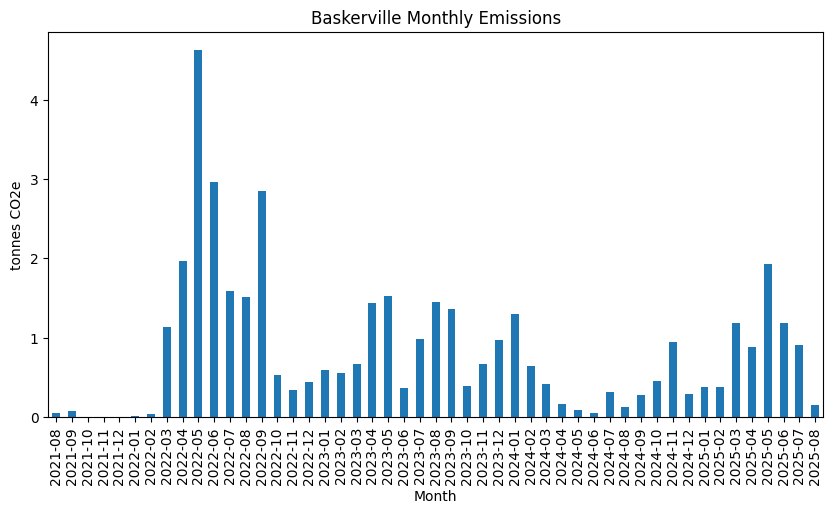

In [14]:
data.groupby("YYYY-MM")["CO2_total_g"].sum().apply(lambda x: x / 1e6).plot(
    kind="bar", 
    title="Baskerville Monthly Emissions", 
    ylabel="tonnes CO2e", 
    xlabel="Month", 
    figsize=(10,5)
)

In [15]:
data.groupby("YYYY-MM")["CO2_total_g"].sum()["2024-09":].sum() / 1e6 # in tonnes CO2

np.float64(8.968002079327704)

i.e. In 2025, we emitted ~2 UK persons worth of CO2 or ~4 flights from New York to Melbourne.

In [16]:
data.groupby("YYYY")["CO2_total_g"].sum() / 1e6 # in tonnes CO2

YYYY
2021     0.134047
2022    17.996329
2023    10.975992
2024     5.077792
2025     6.997147
Name: CO2_total_g, dtype: float64

<Axes: title={'center': 'Baskerville Yearly Emissions'}, xlabel='Year', ylabel='tonnes CO2e'>

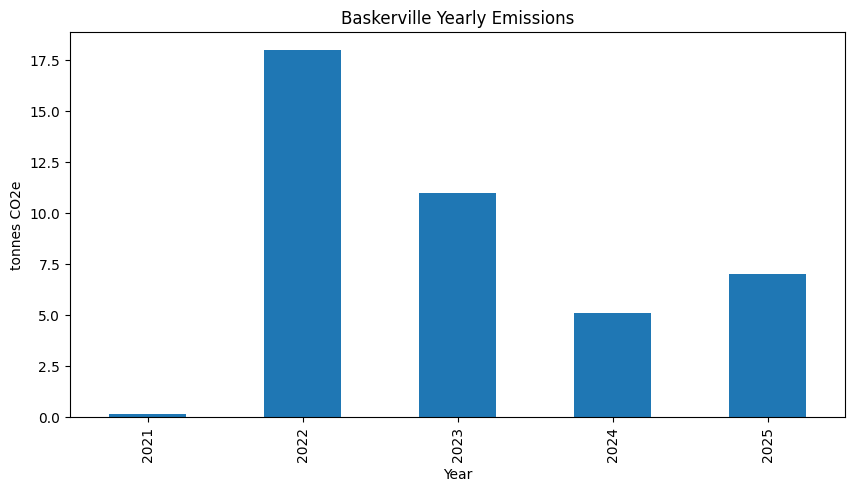

In [21]:
data.groupby("YYYY")["CO2_total_g"].sum().apply(lambda x: x/1e6).plot(
    kind="bar", 
    title="Baskerville Yearly Emissions", 
    ylabel="tonnes CO2e", 
    xlabel="Year", 
    figsize=(10,5)
)